In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings('ignore')

In [114]:
df = pd.read_csv("insurance.csv")

print("=" * 80)
print("📊 DATASET LOADED")
print("=" * 80)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())

📊 DATASET LOADED
Shape: 1338 rows × 7 columns

First 5 rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Column names: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


In [115]:
print("\n" + "=" * 80)
print("🔧 CREATING MISSING VALUES FOR DEMONSTRATION")
print("=" * 80)

# Keep original data
df_original = df.copy()

# Set random seed
np.random.seed(42)

# Add missing values
missing_percentage = 0.05  # 5% missing

print(f"\nAdding ~{missing_percentage*100:.0f}% missing values to each column...")

# Add missing to numerical columns
for col in ['age', 'bmi', 'children']:
    n_missing = int(len(df) * missing_percentage)
    missing_indices = np.random.choice(df.index, size=n_missing, replace=False)
    df.loc[missing_indices, col] = np.nan
    print(f"   ✅ Added {n_missing} missing values to '{col}'")

# Add missing to categorical columns
for col in ['sex', 'smoker', 'region']:
    n_missing = int(len(df) * missing_percentage)
    missing_indices = np.random.choice(df.index, size=n_missing, replace=False)
    df.loc[missing_indices, col] = np.nan
    print(f"   ✅ Added {n_missing} missing values to '{col}'")

# Add missing to target
n_missing_target = int(len(df) * 0.02)  # 2% missing in target
missing_indices = np.random.choice(df.index, size=n_missing_target, replace=False)
df.loc[missing_indices, 'charges'] = np.nan
print(f"   ⚠️  Added {n_missing_target} missing values to 'charges' (target)")

print(f"\n📊 Dataset after adding missing values:")
print(f"Total rows: {len(df)}")
print("\n")



🔧 CREATING MISSING VALUES FOR DEMONSTRATION

Adding ~5% missing values to each column...
   ✅ Added 66 missing values to 'age'
   ✅ Added 66 missing values to 'bmi'
   ✅ Added 66 missing values to 'children'
   ✅ Added 66 missing values to 'sex'
   ✅ Added 66 missing values to 'smoker'
   ✅ Added 66 missing values to 'region'
   ⚠️  Added 26 missing values to 'charges' (target)

📊 Dataset after adding missing values:
Total rows: 1338




In [116]:
print("=" * 80)
print("🔧 HANDLING MISSING VALUES - ITERATIVE IMPUTER METHOD")
print("=" * 80)

num_cols = ['age', 'bmi', 'children']
cat_cols = ['sex', 'smoker', 'region']

print("\n📊 Missing values BEFORE handling:")
print("-" * 80)
missing_summary = df.isnull().sum()
print(missing_summary)
print(f"\nTotal missing values: {missing_summary.sum()}")
print(f"Total rows: {len(df)}")

# Show percentage
if missing_summary.sum() > 0:
    print("\n📈 Missing values percentage:")
    print("-" * 80)
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            missing_pct = (missing_count / len(df)) * 100
            print(f"   {col:12} : {missing_count:4} missing ({missing_pct:.2f}%)")

# ===== STEP 1: ENCODE CATEGORICAL VARIABLES FIRST =====
print("\n1️⃣  ENCODING CATEGORICAL VARIABLES:")
print("-" * 80)
print("   (Required for Iterative Imputer to work on all features)")

# Create label encoders for categorical columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    # Handle NaN by temporarily filling with a placeholder
    mask = df[col].notna()
    df.loc[mask, col + '_encoded'] = le.fit_transform(df.loc[mask, col])
    df.loc[~mask, col + '_encoded'] = np.nan
    label_encoders[col] = le
    print(f"   ✅ Encoded '{col}': {dict(zip(le.classes_, le.transform(le.classes_)))}")

# ===== STEP 2: APPLY ITERATIVE IMPUTER =====
print("\n2️⃣  APPLYING ITERATIVE IMPUTER:")
print("-" * 80)
print("   This method uses machine learning to predict missing values")
print("   based on other features (more accurate than median/mode!)")

# Prepare data for imputer
impute_cols = num_cols + [col + '_encoded' for col in cat_cols] + ['charges']
df_for_impute = df[impute_cols].copy()

print(f"\n   Columns to impute: {impute_cols}")
print(f"   Total features: {len(impute_cols)}")

# Create Iterative Imputer
print("\n   Creating Iterative Imputer...")
print("   • max_iter=10 (number of imputation rounds)")
print("   • random_state=42 (for reproducibility)")
print("   • initial_strategy='mean' (starting point)")

imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    initial_strategy='mean',
    verbose=0
)

# Fit and transform
print("\n   🔄 Fitting and transforming data...")
print("   (This may take a few seconds...)")

df_imputed = pd.DataFrame(
    imputer.fit_transform(df_for_impute),
    columns=impute_cols,
    index=df.index
)

print("   ✅ Imputation complete!")

# ===== STEP 3: DECODE CATEGORICAL VARIABLES =====
print("\n3️⃣  DECODING CATEGORICAL VARIABLES:")
print("-" * 80)

for col in cat_cols:
    encoded_col = col + '_encoded'
    # Round to nearest integer and clip to valid range
    df_imputed[encoded_col] = df_imputed[encoded_col].round().astype(int)
    n_classes = len(label_encoders[col].classes_)
    df_imputed[encoded_col] = df_imputed[encoded_col].clip(0, n_classes - 1)

    # Decode back to original categories
    df[col] = label_encoders[col].inverse_transform(df_imputed[encoded_col])
    print(f"   ✅ Decoded '{col}' back to original categories")

# Update numerical columns and target
for col in num_cols + ['charges']:
    df[col] = df_imputed[col]
    print(f"   ✅ Updated '{col}' with imputed values")

# ===== STEP 4: VERIFY RESULTS =====
print("\n4️⃣  VERIFICATION:")
print("-" * 80)

print("\n📊 Missing values AFTER Iterative Imputer:")
missing_after = df.isnull().sum()
print(missing_after)

if missing_after.sum() == 0:
    print("\n✅✅✅ ALL MISSING VALUES HANDLED SUCCESSFULLY!")
    print("✅ Using ITERATIVE IMPUTER - More accurate than median/mode!")
    print(f"✅ Dataset has {len(df)} complete rows ready for modeling")
else:
    print(f"\n⚠️  Warning: Still {missing_after.sum()} missing values!")

# Compare some imputed values with originals
print("\n📊 COMPARISON: Original vs Imputed (first 5 that had missing):")
print("-" * 80)
comparison_shown = 0
for idx in df_original.index:
    if comparison_shown >= 5:
        break
    for col in num_cols:
        if pd.isna(df_original.loc[idx, col]) and not pd.isna(df.loc[idx, col]):
            print(f"   Row {idx}, {col:10}: Original=NaN → Imputed={df.loc[idx, col]:.2f}")
            comparison_shown += 1
            if comparison_shown >= 5:
                break

print("\n")


🔧 HANDLING MISSING VALUES - ITERATIVE IMPUTER METHOD

📊 Missing values BEFORE handling:
--------------------------------------------------------------------------------
age         66
sex         66
bmi         66
children    66
smoker      66
region      66
charges     26
dtype: int64

Total missing values: 422
Total rows: 1338

📈 Missing values percentage:
--------------------------------------------------------------------------------
   age          :   66 missing (4.93%)
   sex          :   66 missing (4.93%)
   bmi          :   66 missing (4.93%)
   children     :   66 missing (4.93%)
   smoker       :   66 missing (4.93%)
   region       :   66 missing (4.93%)
   charges      :   26 missing (1.94%)

1️⃣  ENCODING CATEGORICAL VARIABLES:
--------------------------------------------------------------------------------
   (Required for Iterative Imputer to work on all features)
   ✅ Encoded 'sex': {'female': np.int64(0), 'male': np.int64(1)}
   ✅ Encoded 'smoker': {'no': np.int64(0)

In [117]:
print("\n" + "=" * 80)
print("🧹 CLEANING UP TEMPORARY ENCODED COLUMNS")
print("=" * 80)
encoded_cols_to_drop = [col + '_encoded' for col in cat_cols if col + '_encoded' in df.columns]
df = df.drop(columns=encoded_cols_to_drop)
print(f"✅ Dropped temporary columns: {encoded_cols_to_drop}")

# Re-verify missing values after dropping columns
print("\n📊 Missing values AFTER dropping temporary columns:")
missing_after_drop = df.isnull().sum()
print(missing_after_drop)

if missing_after_drop.sum() == 0:
    print("\n✅✅✅ ALL MISSING VALUES HANDLED SUCCESSFULLY!")
    print(f"✅ Dataset has {len(df)} complete rows ready for modeling")
else:
    print(f"\n⚠️  Warning: Still {missing_after_drop.sum()} missing values after cleanup!")
print("\n")


🧹 CLEANING UP TEMPORARY ENCODED COLUMNS
✅ Dropped temporary columns: ['sex_encoded', 'smoker_encoded', 'region_encoded']

📊 Missing values AFTER dropping temporary columns:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

✅✅✅ ALL MISSING VALUES HANDLED SUCCESSFULLY!
✅ Dataset has 1338 complete rows ready for modeling




In [118]:
print("=" * 80)
print("📋 SPLITTING FEATURES & TARGET")
print("=" * 80)

X = df.drop("charges", axis=1)
y = df["charges"]

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"Target column: charges (insurance cost)")
print("\n")

📋 SPLITTING FEATURES & TARGET
Features (X): (1338, 6)
Target (y): (1338,)

Feature columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
Target column: charges (insurance cost)




In [119]:
print("=" * 80)
print("⚙️ CREATING PREPROCESSING PIPELINE")
print("=" * 80)

cat_cols_original = ['sex', 'smoker', 'region']
num_cols_original = ['age', 'bmi', 'children']

preprocess = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first", sparse_output=False), cat_cols_original),
    ("scale", StandardScaler(), num_cols_original)
], remainder='passthrough')

print("\n✅ Preprocessing steps:")
print("   1. OneHotEncoder for categorical columns:", cat_cols_original)
print("   2. StandardScaler for numerical columns:", num_cols_original)
print("\n")

⚙️ CREATING PREPROCESSING PIPELINE

✅ Preprocessing steps:
   1. OneHotEncoder for categorical columns: ['sex', 'smoker', 'region']
   2. StandardScaler for numerical columns: ['age', 'bmi', 'children']




In [120]:
print("=" * 80)
print("🤖 CREATING LASSO REGRESSION MODEL")
print("=" * 80)

model = Pipeline([
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lasso", Lasso(alpha=0.01, max_iter=10000, random_state=42))
])

print("\n✅ Model pipeline created:")
print("   1. Preprocessing (OneHot + Scaling)")
print("   2. Polynomial Features (degree=2)")
print("   3. Lasso Regression (alpha=0.01)")
print("\n")


🤖 CREATING LASSO REGRESSION MODEL

✅ Model pipeline created:
   1. Preprocessing (OneHot + Scaling)
   2. Polynomial Features (degree=2)
   3. Lasso Regression (alpha=0.01)




In [121]:
print("=" * 80)
print("✂️ TRAIN/TEST SPLIT")
print("=" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print("\n")

✂️ TRAIN/TEST SPLIT

Training set: 1070 samples (80.0%)
Testing set:  268 samples (20.0%)




In [122]:
print("=" * 80)
print("🎓 TRAINING MODEL...")
print("=" * 80)

model.fit(X_train, y_train)

print("\n✅ Model trained successfully!")
print("\n")

🎓 TRAINING MODEL...

✅ Model trained successfully!




In [123]:
print("=" * 80)
print("📊 MODEL EVALUATION")
print("=" * 80)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Training metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Testing metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n📈 TRAINING SET Performance:")
print("-" * 80)
print(f"   MAE:      ${train_mae:,.2f}")
print(f"   RMSE:     ${train_rmse:,.2f}")
print(f"   R² Score: {train_r2:.4f} ({train_r2*100:.2f}%)")

print("\n📊 TESTING SET Performance:")
print("-" * 80)
print(f"   MAE:      ${test_mae:,.2f}")
print(f"   RMSE:     ${test_rmse:,.2f}")
print(f"   R² Score: {test_r2:.4f} ({test_r2*100:.2f}%)")

print("\n💡 INTERPRETATION:")
print("-" * 80)
print(f"   • Model explains {test_r2*100:.1f}% of variance in insurance charges")
print(f"   • Average prediction error: ${test_mae:,.0f} (MAE)")
print(f"   • Root mean squared error: ${test_rmse:,.0f} (RMSE)")

# Check overfitting
if abs(train_r2 - test_r2) < 0.05:
    print(f"\n   ✅ Good fit! No significant overfitting")
    print(f"      Training R²: {train_r2:.4f}, Testing R²: {test_r2:.4f}")
elif train_r2 > test_r2 + 0.1:
    print(f"\n   ⚠️  Possible overfitting detected")
    print(f"      Training R²: {train_r2:.4f}, Testing R²: {test_r2:.4f}")
else:
    print(f"\n   ℹ️  Model performance difference: {abs(train_r2-test_r2):.4f}")

print("\n")


📊 MODEL EVALUATION

📈 TRAINING SET Performance:
--------------------------------------------------------------------------------
   MAE:      $2,973.90
   RMSE:     $4,820.74
   R² Score: 0.8379 (83.79%)

📊 TESTING SET Performance:
--------------------------------------------------------------------------------
   MAE:      $2,965.65
   RMSE:     $4,683.25
   R² Score: 0.8567 (85.67%)

💡 INTERPRETATION:
--------------------------------------------------------------------------------
   • Model explains 85.7% of variance in insurance charges
   • Average prediction error: $2,966 (MAE)
   • Root mean squared error: $4,683 (RMSE)

   ✅ Good fit! No significant overfitting
      Training R²: 0.8379, Testing R²: 0.8567




📈 CREATING VISUALIZATIONS...


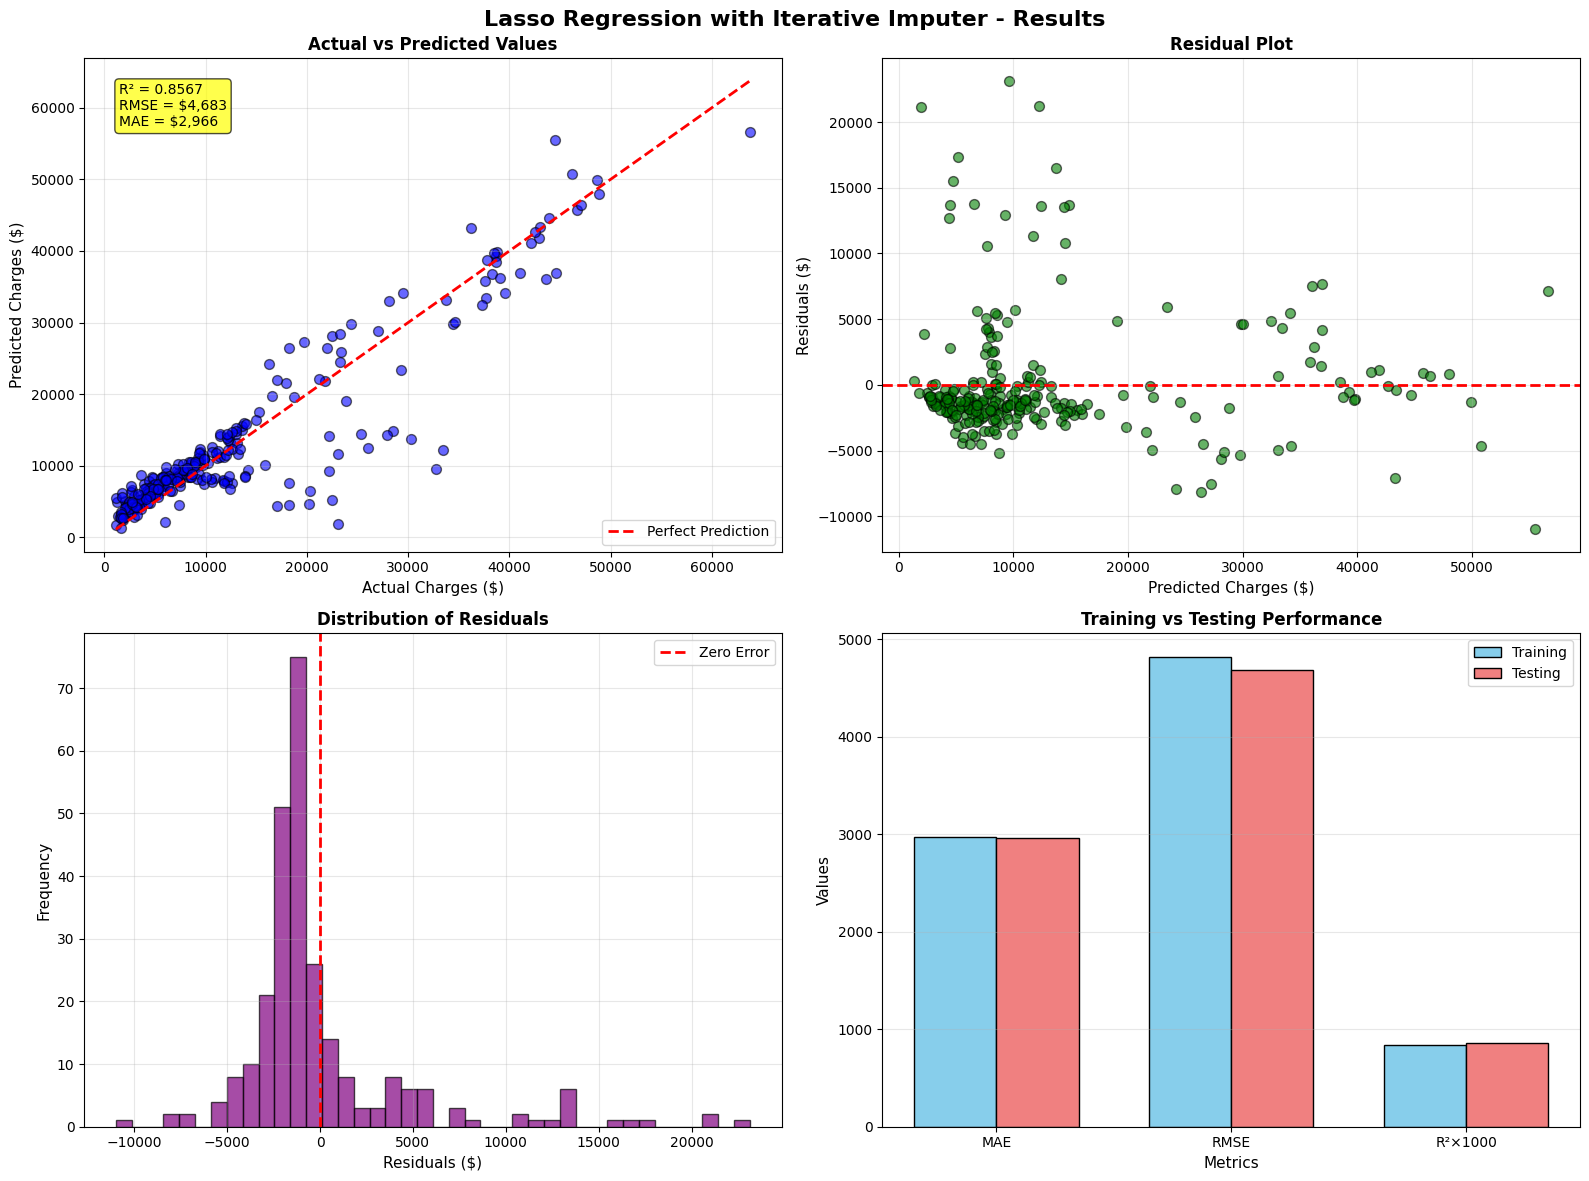

✅ Visualizations created!



In [124]:
print("=" * 80)
print("📈 CREATING VISUALIZATIONS...")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Lasso Regression with Iterative Imputer - Results',
             fontsize=16, fontweight='bold')

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='blue',
                   edgecolors='black', s=50)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Charges ($)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Charges ($)', fontsize=11)
axes[0, 0].set_title('Actual vs Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].text(0.05, 0.95,
                f'R² = {test_r2:.4f}\nRMSE = ${test_rmse:,.0f}\nMAE = ${test_mae:,.0f}',
                transform=axes[0, 0].transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# 2. Residuals Plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6, color='green',
                   edgecolors='black', s=50)
axes[0, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Charges ($)', fontsize=11)
axes[0, 1].set_ylabel('Residuals ($)', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Residuals Distribution
axes[1, 0].hist(residuals, bins=40, color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Error')
axes[1, 0].set_xlabel('Residuals ($)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Training vs Testing Comparison
metrics = ['MAE', 'RMSE', 'R²×1000']
train_values = [train_mae, train_rmse, train_r2*1000]
test_values = [test_mae, test_rmse, test_r2*1000]

x_pos = np.arange(len(metrics))
width = 0.35

axes[1, 1].bar(x_pos - width/2, train_values, width, label='Training',
               color='skyblue', edgecolor='black')
axes[1, 1].bar(x_pos + width/2, test_values, width, label='Testing',
               color='lightcoral', edgecolor='black')
axes[1, 1].set_xlabel('Metrics', fontsize=11)
axes[1, 1].set_ylabel('Values', fontsize=11)
axes[1, 1].set_title('Training vs Testing Performance', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizations created!\n")

In [125]:
print("=" * 80)
print("🔮 PREDICTION EXAMPLES")
print("=" * 80)

# Example 1: Non-smoker
example1 = pd.DataFrame({
    'age': [30],
    'sex': ['male'],
    'bmi': [25.0],
    'children': [1],
    'smoker': ['no'],
    'region': ['southwest']
})

pred1 = model.predict(example1)[0]

print("\n👤 Example 1: Non-smoker")
print("-" * 80)
print("   Age: 30, Male, BMI: 25.0, Children: 1")
print("   Smoker: NO, Region: Southwest")
print(f"   💰 Predicted Cost: ${pred1:,.2f}")

# Example 2: Smoker
example2 = pd.DataFrame({
    'age': [30],
    'sex': ['male'],
    'bmi': [25.0],
    'children': [1],
    'smoker': ['yes'],
    'region': ['southwest']
})

pred2 = model.predict(example2)[0]

print("\n👤 Example 2: Smoker")
print("-" * 80)
print("   Age: 30, Male, BMI: 25.0, Children: 1")
print("   Smoker: YES 🚨, Region: Southwest")
print(f"   💰 Predicted Cost: ${pred2:,.2f}")
print(f"   📊 Difference: ${pred2 - pred1:,.2f} MORE for smokers!")

print("\n")

🔮 PREDICTION EXAMPLES

👤 Example 1: Non-smoker
--------------------------------------------------------------------------------
   Age: 30, Male, BMI: 25.0, Children: 1
   Smoker: NO, Region: Southwest
   💰 Predicted Cost: $4,754.99

👤 Example 2: Smoker
--------------------------------------------------------------------------------
   Age: 30, Male, BMI: 25.0, Children: 1
   Smoker: YES 🚨, Region: Southwest
   💰 Predicted Cost: $22,350.82
   📊 Difference: $17,595.83 MORE for smokers!




In [127]:
print("=" * 80)
print("✅ ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)

print("\n📊 FINAL MODEL PERFORMANCE:")
print(f"   • R² Score:  {test_r2:.4f} ({test_r2*100:.1f}% variance explained)")
print(f"   • RMSE:      ${test_rmse:,.2f}")
print(f"   • MAE:       ${test_mae:,.2f}")

✅ ANALYSIS COMPLETE - SUMMARY

📊 FINAL MODEL PERFORMANCE:
   • R² Score:  0.8567 (85.7% variance explained)
   • RMSE:      $4,683.25
   • MAE:       $2,965.65
